In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from tqdm.auto import tqdm#show loop progress
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models


import argparse
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time
from torchvision.models.inception import inception_v3
import numpy as np
from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torch
from torch import nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/cnn-c1-fashion-mnist/__results__.html
/kaggle/input/cnn-c1-fashion-mnist/__notebook__.ipynb
/kaggle/input/cnn-c1-fashion-mnist/__output__.json
/kaggle/input/cnn-c1-fashion-mnist/model.ckpt
/kaggle/input/cnn-c1-fashion-mnist/custom.css
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/processed/training.pt
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/processed/test.pt
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-labels-idx1-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-images-idx3-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-labels-idx1-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-images-idx3-ubyte
/kaggle/input/cnn-c1-fashion-mnis

In [2]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn_c1 = CNN()
cnn_c1.load_state_dict(torch.load('../input/cnn-c1-fashion-mnist/model.ckpt'))
cnn_c1.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [3]:
def find_data(trainloader,epoch):
    with torch.no_grad():
        data = []
        for images in trainloader:
            images = images.to('cpu')
            #print(images.size())
            test = Variable(images.float())
            #print(test.size())
            outputs = cnn_c1(test)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(images)):
                data.append([images[i],predicted[i]])
    len(data)
    gan_testloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    torch.save(gan_testloader, './gan_data_epoch_{}'.format(epoch))

In [4]:
train_loader = torch.load('../input/fashion-mnist-for-dis-score/dis_score_loader')
#test_loader = torch.load('../input/mnist-splitter/svdash_dataloader')
len(train_loader)

625

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(74, 1024)
        self.fc_2 = nn.Linear(1024, 7*7*128)

        self.bn_1 = nn.BatchNorm1d(1024)
        self.bn_2 = nn.BatchNorm2d(128)
        self.bn_3 = nn.BatchNorm2d(64)

        self.upconv_1 = nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=1, bias=False)
        self.upconv_2 = nn.ConvTranspose2d(64, 1, (4,4), stride=2, padding=1, bias=False)

    def forward(self,x):
        # Construct network described in paper
        x = self.bn_1(F.relu(self.fc_1(x)))
        x = self.fc_2(x)
        x = x.view(-1,128,7,7)
        x = self.bn_2(F.relu(x))
        x = self.bn_3(F.relu(self.upconv_1(x)))
        x = F.sigmoid(self.upconv_2(x))
        return x

class DiscriminatorFrontEnd(nn.Module):
    def __init__(self):
        super(DiscriminatorFrontEnd, self).__init__()

        self.fc = nn.Linear(7*7*128, 1024)

        self.bn_1 = nn.BatchNorm2d(128)
        self.bn_2 = nn.BatchNorm1d(1024)

        self.conv_1 = nn.Conv2d(1, 64, (4,4), stride=2, padding=1, bias=False)
        self.conv_2 = nn.Conv2d(64, 128, (4,4), stride=2, padding=1, bias=False)

    def forward(self,x):
        # Construct network described in paper
        # Input = 1x28x28
        x = F.leaky_relu(self.conv_1(x))
        # x.shape = 64x14x14
        x = F.leaky_relu(self.conv_2(x))
        # x.shape = 128x7x7
        x = self.bn_1(x)
        x = x.view(-1,7*7*128)
        x = self.fc(x)
        x = self.bn_2(x)
        return x

class DiscriminatorBackend(nn.Module):
    def __init__(self):
        super(DiscriminatorBackend, self).__init__()
        self.fc = nn.Linear(1024, 1)
    def forward(self,x):
        x = F.sigmoid(self.fc(x))
        return x

class DiscriminatorInfo(nn.Module):
    def __init__(self):
        super(DiscriminatorInfo, self).__init__()
        self.fc_1 = nn.Linear(1024, 128)
        self.fc_2 = nn.Linear(128,12)

        self.bn = nn.BatchNorm1d(128)

    def forward(self,x):
        x = self.fc_1(x)
        x = F.leaky_relu(self.bn(x))
        x = self.fc_2(x)
        return x
import numpy as np
import torch
import matplotlib.pyplot as plt

def sample_noise(batch_size, num_category = 10, num_conti=2, noise_dim=62):
    idx = np.random.randint(num_category, size=batch_size)
    category_code = np.zeros((batch_size, num_category))
    category_code[range(batch_size),idx] = 1.0
    conti_code = np.random.uniform(-1.0,1.0,(batch_size,num_conti))

    random_noise = np.random.uniform(-1.0,1.0,(batch_size,noise_dim))

    z = torch.cat((torch.Tensor(random_noise),torch.Tensor(category_code),torch.Tensor(conti_code)),dim=1)

    return z, idx

def get_test_noise(num_category = 10, num_conti=2, noise_dim=62):
    fixed_noise = np.random.uniform(-1.0,1.0,(noise_dim))
    # z1 : fix c2
    # z2 : fix c1
    z1 = []
    z2 = []
    for cat in range(num_category):
        category_code = np.zeros((num_category))
        category_code[cat] = 1.0
        for c in np.arange(-2,2.1,0.5):
            z1.append(np.concatenate([fixed_noise,category_code,np.array([c]),np.array([0])]))
            z2.append(np.concatenate([fixed_noise,category_code,np.array([0]),np.array([c])]))
    z1 = torch.Tensor(np.array(z1))
    z2 = torch.Tensor(np.array(z2))

    return z1,z2

def save_fig(z,G,fig_name,num_category = 10,num_conti=9):
    fake_x = G(z).data.cpu().numpy().reshape(num_category*num_conti,28,28)
    fig, axs = plt.subplots(num_category,num_conti,figsize=(20,20))
    for i in range(num_category):
        for j in range(num_conti):
            axs[i,j].get_xaxis().set_visible(False)
            axs[i,j].get_yaxis().set_visible(False)
            axs[i,j].imshow(fake_x[i*num_conti+j], cmap='gray')
    plt.savefig(fig_name,bbox_inches='tight')
    plt.close()

    
#from InfoGAN import Generator, DiscriminatorFrontEnd, DiscriminatorBackend,DiscriminatorInfo
#from util import *
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE = 64
NUM_EPOCHS = 201
USE_GPU = True

DISPLAY_STEP = 100
PLOT_EPOCH = 5
#mnist_dataset = dset.MNIST(root='./data/',transform=transforms.ToTensor(),download=True)
#dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

dataloader = train_loader
D = DiscriminatorFrontEnd()
G = Generator()
TF = DiscriminatorBackend()
Q = DiscriminatorInfo()

# Loss function
D_criterion = nn.BCEWithLogitsLoss()
Q_discr_criterion = nn.CrossEntropyLoss()
Q_conti_criterion = nn.MSELoss()


if USE_GPU:
    D = D.cuda()
    G = G.cuda()
    TF = TF.cuda()
    Q = Q.cuda()
    D_criterion = D_criterion.cuda()
    Q_discr_criterion = Q_discr_criterion.cuda()
    Q_conti_criterion = Q_conti_criterion.cuda()

optimD = optim.Adam([{'params':D.parameters()}, {'params':TF.parameters()}], lr=0.0002)
optimG = optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=0.001)

training_message = 'epoch-{:3}-step-{:3}-D_loss-{:.6f}-GQ_loss-{:.4f}'
epoch_end_message = 'epoch-{:3}-D_loss-{:.4f}-GQ_loss-{:.4f}-Image_loss-{:.4f}-Disc_loss-{:.4f}-Conti_loss-{:.4f}'

log = open('infogan.log','w')
log_message = '{:.4f},{:.4f},{:.4f},{:.4f}\n'
log.write('D_loss,G_loss,Disc_loss,Conti_loss\n')


demo_z1, demo_z2 = get_test_noise()
demo_z1 = Variable(demo_z1.cuda()) if USE_GPU else Variable(demo_z1)
demo_z2 = Variable(demo_z2.cuda()) if USE_GPU else Variable(demo_z2)


generated_images = []
psnr_score = []
mmd_score = []
fid_score = []
is_score= []
checkpoint = [1,10,20,30,40,50,100,150,200]
for epoch in range(NUM_EPOCHS):
    # Output Demo
    fake_image_array = []
    real_array = []
    if (epoch%PLOT_EPOCH) == 0:
        save_fig(demo_z1,G,'./wiegthed_z1_epoch{}.jpg'.format(epoch))
        save_fig(demo_z2,G,'./wiegthed_z2_epoch{}.jpg'.format(epoch))

    D_loss = 0 # Accumalate loss of D
    G_loss = 0 # Accumalate loss of G
    Q_loss_dis = 0 # Accumalate loss of Q (discrete)
    Q_loss_conti = 0 # Accumalate loss of Q (continuous)
    for step,batch_data in enumerate(dataloader):
        batch_size = batch_data[0].size(0)
        
        # Step 1.
        optimD.zero_grad()
        ### Real Images
        real_x = batch_data[0].cuda() if USE_GPU else batch_data[0]
        real_x = Variable(real_x)
        conv_feature_1 = D(real_x)
        prob_real = TF(conv_feature_1)
        real_label = torch.ones(batch_size).cuda() if USE_GPU else torch.ones(batch_size)
        real_label = Variable(real_label.view(-1,1),requires_grad=False)
        D_real_loss = D_criterion(prob_real,real_label)
        D_real_loss.backward()
        ### Fake Images
        z, fake_idx = sample_noise(batch_size)
        z = Variable(torch.Tensor(z).cuda()) if USE_GPU else Variable(torch.Tensor(z))
        fake_x = G(z)
        
        if epoch in checkpoint:
            generated_images.append(fake_x)
            fake_image_array.append(fake_x)
            real_array.append(real_x)
        conv_feature_2 = D(fake_x.detach())
        prob_fake = TF(conv_feature_2)
        real_label = torch.zeros(batch_size).cuda() if USE_GPU else torch.zeros(batch_size)
        real_label = Variable(real_label.view(-1,1),requires_grad=False)
        D_fake_loss = D_criterion(prob_fake,real_label)
        D_fake_loss.backward()

        D_loss += D_real_loss+D_fake_loss
        optimD.step()
        
        # Step 2.
        optimG.zero_grad()
        ### Image Reality
        conv_feature_3 = D(fake_x)
        discriminator_prediction = TF(conv_feature_3)
        fake_label = torch.ones(batch_size).cuda() if USE_GPU else torch.ones(batch_size)
        fake_label = Variable(fake_label.view(-1,1),requires_grad=False)
        generator_loss = D_criterion(discriminator_prediction,fake_label)
        G_loss += generator_loss
        ### Mutaul Info
        pred_c = Q(conv_feature_3)
        fake_idx = torch.LongTensor(fake_idx).cuda() if USE_GPU else torch.LongTensor(fake_idx)
        fake_idx = Variable(fake_idx,requires_grad=False)
        digit_classify_loss = Q_discr_criterion(pred_c[:,:10],fake_idx)
        Q_loss_dis += digit_classify_loss
        conti_loss = Q_conti_criterion(pred_c[:,10:],z[:,-2:])
        Q_loss_conti += conti_loss
        
        if epoch >= 50:
            w1 = 1.0
            w2 = 1.0
        else:
            w1 = 0.0
            w2 = 0.0
        
        G_Q_loss = generator_loss + w1*digit_classify_loss + w2*conti_loss
        G_Q_loss.backward()
        optimG.step()
        
        log.write(log_message.format(float((D_real_loss+D_fake_loss).data.cpu().numpy()),
                                     float(generator_loss.data.cpu().numpy()),
                                     float(digit_classify_loss.data.cpu().numpy()),
                                     float(conti_loss.data.cpu().numpy())))
        
        if step%DISPLAY_STEP == 0:
            print(training_message.format(epoch+1,step,float(D_loss.data.cpu().numpy())/(step+1),
                                          float((G_loss+Q_loss_dis+Q_loss_conti).data.cpu().numpy())/(step+1)),
                 flush=True,end='\r')
    # End of epoch
    D_loss = float(D_loss.data.cpu().numpy())/(step+1)
    G_loss = float(G_loss.data.cpu().numpy())/(step+1)
    Q_loss_dis = float(Q_loss_dis.data.cpu().numpy())/(step+1)
    Q_loss_conti = float(Q_loss_conti.data.cpu().numpy())/(step+1)
    print(epoch_end_message.format(epoch+1,D_loss,G_loss+Q_loss_dis+Q_loss_conti,G_loss,Q_loss_dis,Q_loss_conti))

         
    if epoch in checkpoint:
        print("========E=======P========O========C=========H=======:",epoch)
        temp_image = []
        for curr in generated_images:
            for i in curr:
                temp_image.append(i)
        trainloader = torch.utils.data.DataLoader(temp_image, batch_size=64, shuffle=True)
        find_data(trainloader,epoch)
        generated_images = []

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch-  1-D_loss-1.3018-GQ_loss-3.4601-Image_loss-0.5723-Disc_loss-2.3631-Conti_loss-0.5246
epoch-  2-D_loss-1.1634-GQ_loss-3.5955-Image_loss-0.6729-Disc_loss-2.3644-Conti_loss-0.5583
========E=======P========O========C=========H=======: 1
epoch-  3-D_loss-1.1835-GQ_loss-3.5750-Image_loss-0.6788-Disc_loss-2.3599-Conti_loss-0.5363
epoch-  4-D_loss-1.1934-GQ_loss-3.6056-Image_loss-0.6858-Disc_loss-2.3721-Conti_loss-0.5477
epoch-  5-D_loss-1.1838-GQ_loss-3.5630-Image_loss-0.6858-Disc_loss-2.3622-Conti_loss-0.5150
epoch-  6-D_loss-1.2224-GQ_loss-3.5802-Image_loss-0.6783-Disc_loss-2.3703-Conti_loss-0.5317
epoch-  7-D_loss-1.2770-GQ_loss-3.6409-Image_loss-0.6818-Disc_loss-2.3728-Conti_loss-0.5863
epoch-  8-D_loss-1.2749-GQ_loss-3.6167-Image_loss-0.6813-Disc_loss-2.3617-Conti_loss-0.5736
epoch-  9-D_loss-1.2541-GQ_loss-3.6240-Image_loss-0.6865-Disc_loss-2.3769-Conti_loss-0.5605
epoch- 10-D_loss-1.2542-GQ_loss-3.6305-Image_loss-0.6858-Disc_loss-2.3627-Conti_loss-0.5820
epoch- 11-D_loss-1.2225-

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


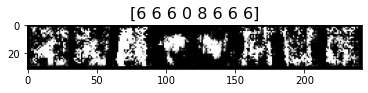

In [6]:
test = torch.load('./gan_data_epoch_1')
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for batch_idx, (temp, target) in enumerate(test):
    img_grid = make_grid(temp[0:8,], nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.detach().cpu().numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()